# Results Optiwise inverse dynamics

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from phd.visualization.styles import styles
from vessel_manoeuvring_models.KF_multiple_sensors import interpolate_and_insert_all
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
from vessel_manoeuvring_models import IMO_evaluation
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
ship_name = "optiwise"

In [4]:
#%reload_kedro

#%reload_kedro
#loaders = {f"polynomial rudder {name}":loader for name,loader in catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL").items()}
loaders={}
#loaders["semiempirical rudder"] = catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia']
loaders["measured rudder"] = catalog.load(f"{ship_name}.models_measured_rudder_force")['semiempirical_covered_inertia']
loaders["MMG_original"] = catalog.load(f"{ship_name}.models_VCT_MMG_rudder_MDL")["original"]
loaders["MMG_quadratic"] = catalog.load(f"{ship_name}.models_VCT_MMG_rudder_MDL")["quadratic"]
#loaders["MMG_rudder"] = catalog.load(f"{ship_name}.models_VCT_MMG_rudder_MDL")["MMG"]
#loaders.pop('polynomial rudder complex')  # for now...

ship_data = catalog.load(f"{ship_name}.ship_data")

[02/05/25 17:34:49] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=181441;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=112661;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=789135;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=993937;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'optiwise.models_measured_rudder_force'          ]8;id=626787;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=9000;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_VCT_MMG_rudder_MDL'             ]8;id=674248;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=143005;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_VCT_MMG_rudder_MDL'             ]8;id=511091;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=90276;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.ship_data' (YAMLDataSet)...            ]8;id=342625;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=774256;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [5]:
models = {name:loader() for name,loader in loaders.items()}
model = models["MMG_quadratic"]

In [6]:
meta_datas_all = catalog.load(f"{ship_name}.test_meta_data")

meta_datas_all = meta_datas_all.groupby('test_type').get_group('zigzag')
mask = meta_datas_all['ship_speed'] > 0.9
meta_datas_all = meta_datas_all.loc[mask].copy()

                    INFO     Loading data from 'optiwise.test_meta_data' (CSVDataSet)...        ]8;id=150337;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=749591;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [7]:
meta_datas = meta_datas_all.loc[[23590, 23591, 23594, 23596]].copy()

## Compare forces

In [8]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
#model = catalog.load(f"{ship_name}.models_VCT")['semiempirical_covered_inertia']()
df_VCT_hydro = subtract_centripetal_and_Coriolis(df_VCT=df_VCT, model=model)

                    INFO     Loading data from 'optiwise.df_VCT_scaled' (CSVDataSet)...         ]8;id=107573;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=14747;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [9]:
round = {
    'u':4,
    'v':4,
    'r':3,
    'delta':3,
}

keys_rounded = [f"{key}_round" for key in round.keys()]

for key,decimals in round.items():
    df_VCT_hydro[f"{key}_round"] = np.round(df_VCT_hydro[key], decimals=decimals)

_=[]
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    for key,decimals in round.items():
        df_EKF_smooth[f"{key}_round"] = np.round(df_EKF_smooth[key], decimals=decimals)

    df_EKF_smooth['time'] = df_EKF_smooth.index

    mask = df_EKF_smooth.duplicated(keys_rounded)
    df_ = df_EKF_smooth.loc[~mask]

    points = pd.merge(left=df_, right=df_VCT_hydro, how='inner', left_on=keys_rounded, right_on=keys_rounded, suffixes=('','_vct'))
    points.set_index('time', inplace=True)
    assert points.index.is_unique
    points['id'] = id
    #points_all[id]=points
    _.append(points)

points_all = pd.concat(_)
points_all['id'] = points_all['id'].astype(int)

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=330447;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=267981;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=271286;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=299655;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=366869;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=29874;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

[02/05/25 17:34:50] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=54603;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=406664;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=967939;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=605886;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [10]:
eq_X_D = remove_functions(sp.Eq(
            X_D, sp.solve(model.X_eq.subs(model.X_D_eq.rhs, model.X_D_eq.lhs), X_D_)[0]
        ))

eq_Y_D = remove_functions(sp.Eq(
            Y_D, sp.solve(model.Y_eq.subs(model.Y_D_eq.rhs, model.Y_D_eq.lhs), Y_D_)[0]
        ))

eq_N_D = remove_functions(sp.Eq(
            N_D, sp.solve(model.N_eq.subs(model.N_D_eq.rhs, model.N_D_eq.lhs), N_D_)[0]
        ))

In [11]:
eq_X_D

Eq(X_D, -X_{\dot{u}}*\dot{u} + Y_{\dot{r}}*r**2 + Y_{\dot{v}}*r*v + \dot{u}*m - m*r**2*x_G - m*r*v)

In [12]:
eq_Y_D

Eq(Y_D, -X_{\dot{u}}*r*u - Y_{\dot{r}}*\dot{r} - Y_{\dot{v}}*\dot{v} + \dot{r}*m*x_G + \dot{v}*m + m*r*u)

In [13]:
eq_N_D

Eq(N_D, I_z*\dot{r} - N_{\dot{r}}*\dot{r} - N_{\dot{v}}*\dot{v} + X_{\dot{u}}*u*v - Y_{\dot{r}}*r*u - Y_{\dot{v}}*u*v + \dot{v}*m*x_G + m*r*u*x_G)

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=747607;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=953248;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=591358;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=628817;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=620128;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=323229;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[02/05/25 17:34:51] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=432452;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=281486;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=309475;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=546305;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

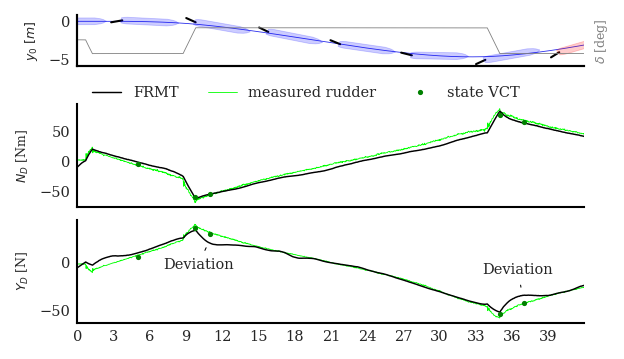

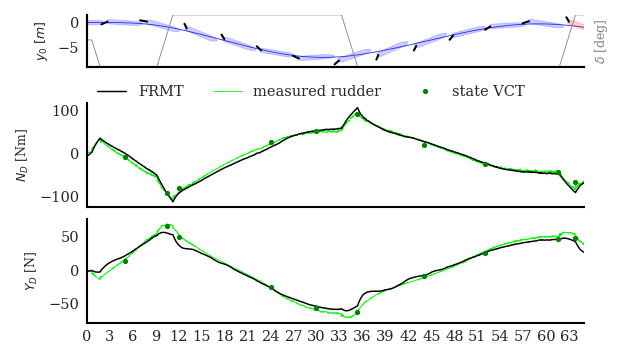

In [14]:
t_maxs = {
    23590 : 42, 
    23594 : 65,
}

units_ = units.copy()
units_.pop('Y_R')

models_ = pd.Series(models)
models_ = models_.drop('MMG_original')
models_ = models_.drop('MMG_quadratic')


for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
    
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    #keys=['N_D','Y_D','alpha']
    keys=['N_D','Y_D',]
    fig = plot_compare_model_forces(model=model, models=models_, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units_, symbols=symbols);
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    #fig.suptitle(name)


    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes[1:],keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='state VCT', zorder=100)


    if id==23590:
        fig.axes[2].annotate("Deviation", xy=(10.8,20), xytext=(10,-10), 
                    size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='bottom')

        fig.axes[2].annotate("Deviation", xy=(36.8,-30), xytext=(36.5,0), 
                    size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='top')

        
    
    fig.axes[1].legend(loc='upper left', ncols=5)
    for ax in fig.axes[2:]:
        try:
            ax.get_legend().set_visible(False)
        except:
            pass


    for ax in fig.axes[0:-1]:
        ax.set_xlabel('')
    fig.axes[-1].set_xlabel('Time [s]')
    
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.45, 1.30), ncol=3)


    
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    for ax in fig.axes:
        ax.xaxis.set_major_locator(loc)
        ax.grid(True, axis='x')
        ax.grid(False, axis='y')
        ax.grid(False)

    fig.set_size_inches(paper.figure_width*0.75,0.75*paper.figure_height)
    
    name = f"measured_rudder_{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    #fig.suptitle(name)
        
    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")

[02/05/25 18:03:01] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=513734;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=61148;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=331730;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=257101;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=531904;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=989577;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=507827;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=422057;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

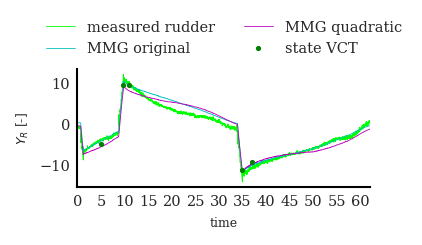

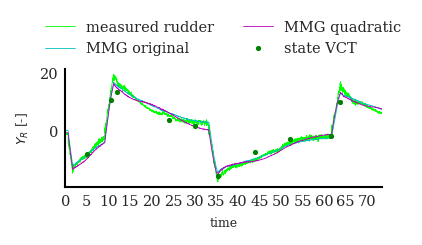

In [87]:
t_maxs = {
    #23590 : 42, 
    #23594 : 65,
}
units_ = units.copy()
units_.pop('Y_R')
for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
#for id, meta_data in meta_datas.loc[[23594]].iterrows():
#for id, meta_data in meta_datas.iterrows():   
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    keys=['Y_R']
    fig = plot_compare_model_forces(model=model, models=models, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units_, 
                                    symbols=symbols, do_track_plot=False);
    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes,keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='state VCT', zorder=100)

    fig.set_size_inches(paper.figure_width,0.5*paper.figure_height)
    #fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.50, 1.20), ncol=4)
    
    loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
    for ax in fig.axes:
        ax.xaxis.set_major_locator(loc)
        ax.grid(True, axis='x')
        ax.grid(False, axis='y')
        ax.grid(False)
        #ax.legend(loc='lower center', ncols=2)
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncols=2)

    fig.set_size_inches(paper.figure_width*0.5,0.5*paper.figure_height)
    
    name = f"rudder_forces_{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    #fig.suptitle(name)
        
    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")

[02/05/25 17:44:50] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=485100;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=136682;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=399690;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=71371;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

<Axes: xlabel='time'>

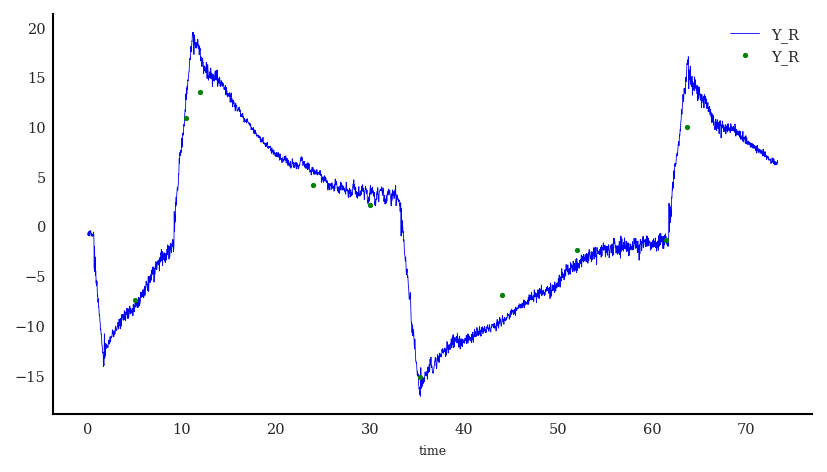

In [64]:
id = 23594
df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
df_EKF_smooth['Y_R'] = df_EKF_smooth['Rudder/1/Fy']

df_ = points_all.groupby(by='id').get_group(id)

fig,ax=plt.subplots()
df_EKF_smooth.plot(y='Y_R', style='b-',ax=ax)
df_.plot(y='Y_R', style='g.',ax=ax)


[02/05/25 17:34:54] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=79121;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=808982;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=10570;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=712592;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[02/05/25 17:34:55] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=326728;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=588834;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=956061;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=942029;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

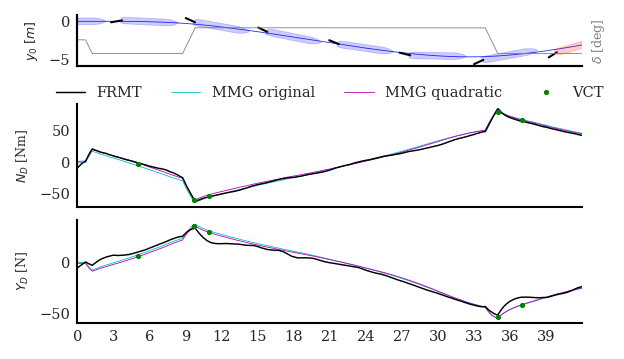

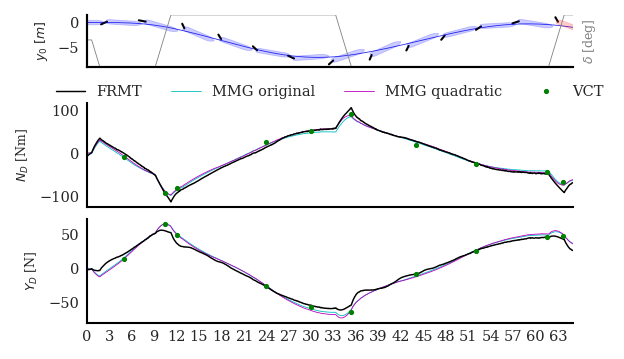

In [16]:
t_maxs = {
    23590 : 42, 
    23594 : 65,
}

units_ = units.copy()
units_.pop('Y_R')

models_ = pd.Series(models)
models_ = models_.drop('measured rudder')

for id, meta_data in meta_datas.loc[[23590,23594]].iterrows():
    
    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

    df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
    df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
    df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    df_EKF_smooth = df_EKF_smooth.loc[0:t_maxs.get(id,np.inf)]
    
    #keys=['N_D','Y_D','alpha']
    keys=['N_D','Y_D',]
    fig = plot_compare_model_forces(model=model, models=models_, data=df_EKF_smooth, styles=styles, keys=keys, delta_corners=False, units=units_, symbols=symbols);
   
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    #fig.suptitle(name)


    if (points_all['id']==id).any():
        points = points_all.groupby(by='id').get_group(id)
        for ax,key in zip(fig.axes[1:],keys):
            if key in points:
                points.plot(y=key,style='g.',ax=ax, label='VCT', zorder=100)


    #if id==23594:
    #    for i,ax in enumerate(fig.axes):
#
    #        if i==0:
    #            continue
    #        
    #        ylims = ax.get_ylim()
    #        ax.fill([43,43,62,62], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1, zorder=-100)
#
    #    for i,ax in enumerate(fig.axes):
#
    #        if i==0:
    #            continue
    #        
    #        ylims = ax.get_ylim()
    #        ax.fill([23,23,33.3,33.3], [ylims[0],ylims[1],ylims[1],ylims[0]], color='blue', edgecolor=None, alpha=0.1, zorder=-100)
#
    #if id==23590:
    #    fig.axes[2].annotate("Deviation", xy=(10.8,20), xytext=(10,-10), 
    #                size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='bottom')
#
    #    fig.axes[2].annotate("Deviation", xy=(36.8,-30), xytext=(36.5,0), 
    #                size=7, arrowprops=dict(arrowstyle='-',lw=0.5), horizontalalignment='center',verticalalignment='top')

        
    
    fig.axes[1].legend(loc='upper left', ncols=5)
    for ax in fig.axes[2:]:
        try:
            ax.get_legend().set_visible(False)
        except:
            pass


    for ax in fig.axes[0:-1]:
        ax.set_xlabel('')
    fig.axes[-1].set_xlabel('Time [s]')
    
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.50, 1.30), ncol=4)


    
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    for ax in fig.axes:
        ax.xaxis.set_major_locator(loc)
        ax.grid(True, axis='x')
        ax.grid(False, axis='y')
        ax.grid(False)

    fig.set_size_inches(paper.figure_width*0.75,0.75*paper.figure_height)
    
    
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
    #fig.suptitle(name)
        
    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")
    

In [17]:
data = df_EKF_smooth
forces_from_motions = model.forces_from_motions(data=data)
force_predictions = {name:predict(model=model, data=data) for name, model in models.items()}

In [18]:
keys = ['Y_D','N_D']
_ = []
for name, df_prediction in force_predictions.items():
    score = pd.Series(name=name)
    for key in keys:
        score[key] = np.sqrt(r2_score(y_true=forces_from_motions[key], y_pred=df_prediction[key]))

    _.append(score)

scores = pd.DataFrame(_)


In [19]:
scores

,Y_D,N_D
measured rudder,0.982954,0.993419
MMG_original,0.987724,0.992138
MMG_quadratic,0.984061,0.994499


(0.9629535841632788, 1.0)

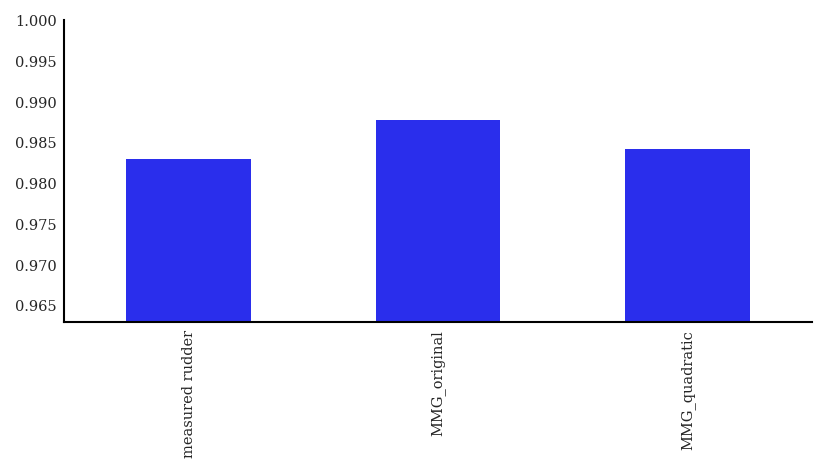

In [20]:
fig,ax=plt.subplots()
scores['Y_D'].plot.bar(ax=ax)
ax.set_ylim(scores['Y_D'].min()-0.02,1)


(0.9629535841632788, 1.0)

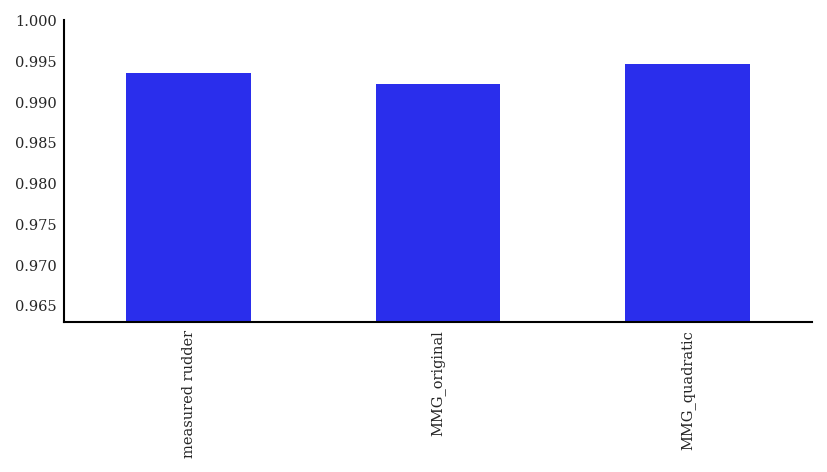

In [21]:
fig,ax=plt.subplots()
scores['N_D'].plot.bar(ax=ax)
ax.set_ylim(scores['Y_D'].min()-0.02,1)

(0.9649126650375308, 1.0)

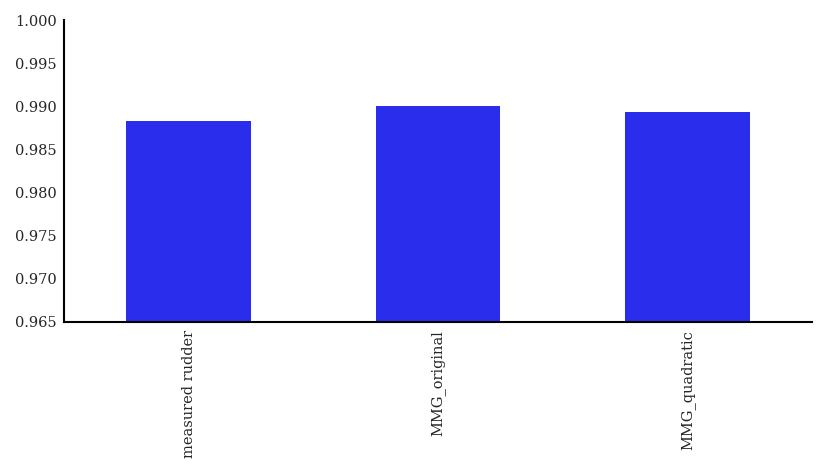

In [22]:
fig,ax=plt.subplots()
scores.mean(axis=1).plot.bar()
ax.set_ylim(scores.mean().min().min()-0.02,1)


## Closed loop simulation

In [23]:
meta_datas['angle_abs'] = meta_datas['angle'].abs()

[02/05/25 17:34:58] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=335439;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=296643;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=384543;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=511278;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

'zigzag 20_20 port'

[02/05/25 17:34:59] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=954896;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=283550;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=988094;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=210346;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[02/05/25 17:35:01] WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=980315;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=593391;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py#1363\1363]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

'zigzag 20_20 stbd'

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=744535;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=624432;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=296748;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=731616;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

'zigzag 10_10 port'

[02/05/25 17:35:02] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=535999;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=173015;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

[02/05/25 17:35:03] INFO     Loading data from 'optiwise.tests' (PartitionedDataset)...         ]8;id=635952;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=470443;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[02/05/25 17:35:04] WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=534554;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=383138;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py#1363\1363]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

'zigzag 10_10 stbd'

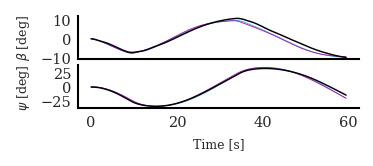

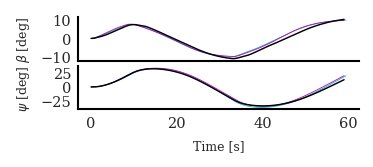

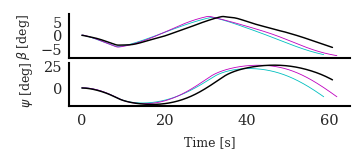

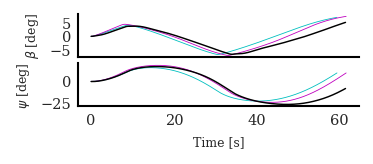

In [24]:
simulations = {}

first = True
for angle, group in meta_datas.sort_values(by=['angle_abs','angle'], ascending=False).groupby(by='angle1', sort=False):

    #fig,ax=plt.subplots()
    include_label=True
    
    for id, meta_data in group.iterrows():
    
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
        df_raw = catalog.load(f"{ship_name}.tests")[str(id)]()
        df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    
        df_EKF_smooth = interpolate_and_insert_all(source=df_raw, destination=df_EKF_smooth)
        df_EKF_smooth['X_RM'] = df_EKF_smooth['Rudder/1/Fx']
        df_EKF_smooth['Y_RM'] = df_EKF_smooth['Rudder/1/Fy']

    
        dataframes = {'Experiment':df_EKF_smooth}
        
        for model_name, model in models.items():

            data = preprocess(df_EKF_smooth,ship_data=model.ship_parameters)
            angle = zigzag_angle(data_MDL=data)
        
            if model_name == "measured rudder":
                #df_simulation = model.simulate(data)
                continue
            else:
                df_simulation = simulate_closed_loop(model=model,data=data)

            if not id in simulations:
                simulations[id] = {}

            simulations[id][model_name] = df_simulation
            
            direction = "port" if angle > 0 else "stbd"
            name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction} {model_name}"
        
            dataframes[model_name] = df_simulation

        dataframes['Experiment'] = dataframes['Experiment'].loc[-1:df_simulation.index[-1]].copy()
        
        #track_plots(dataframes, lpp=model.ship_parameters['L'], beam=model.ship_parameters['B'], include_wind=False, styles=styles, ax=ax, include_label=include_label);
        #fig = ax.get_figure()
        
        direction = "port" if angle > 0 else "stbd"
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
        #fig.suptitle(name)
        #file_name = name.replace("/","_")
        #paper.save_fig(fig, f"track plot {file_name}.svg")
        
        fig = plot(dataframes, keys=['psi','beta'], units=units, styles=styles, ncols=1, include_label=include_label, symbols=symbols);
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
        for ax in fig.axes:
            ax.grid(False)

        fig.set_size_inches(paper.figure_width*0.40,0.25*paper.figure_height)
        if first:
            first = False
            fig.axes[0].legend(['FRMT','MMG\noriginal','MMG\nquadratic'], loc='upper center', bbox_to_anchor=(0.5, 2.0), ncol=3, columnspacing=0.5, handlelength=1)
        else:
            fig.axes[0].get_legend().set_visible(False)

        fig.axes[0].get_legend().set_visible(False)
        
        #fig.suptitle(name)
        file_name = name.replace("/","_")
        paper.save_fig(fig, f"closed loop {file_name}.svg")
        display(file_name)
        
        
        include_label=False

In [25]:
mask = pd.notnull(meta_datas_all['angle'])
meta_datas_all = meta_datas_all.loc[mask].copy()

meta_datas_all[['angle','comment']]

,angle,comment
23590,-10.0,ZZ10/10 SB
23591,10.0,ZZ10/10 SB
23592,-10.0,ZZ10/10 SB
23593,10.0,ZZ10/10 PS
23594,-20.0,ZZ20/20 SB
23595,-20.0,ZZ20/20 SB
23596,20.0,ZZ20/20 PS
23597,20.0,ZZ20/20 PS
23679,-10.0,ZZ10/10 SB
23680,10.0,ZZ10/10 PS


In [26]:
IMO_evaluation.measure_overshoots(df_simulation)


16.05     8.980508
43.58    14.768570
Name: psi, dtype: float64

In [27]:
IMO_evaluation.measure_overshoots(df_EKF_smooth)


time
15.860022     7.432821
47.220002    17.138650
Name: psi, dtype: float64

In [28]:
def pack_overshoots(overshoots):
    overshoot_result = {}
    for n,(time, overshoot) in enumerate(overshoots.items()):  
        overshoot_result[f'overshoot_{n+1}'] = overshoot
        overshoot_result[f't_{n+1}'] = time

    return overshoot_result

In [29]:
_ = []
for id, meta_data in meta_datas_all.iterrows():
    
    try:
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    except:
        continue
    #df_EKF_smooth = catalog.load(f"{ship_name}.tests")[str(id)]()
    
    overshoots = IMO_evaluation.measure_overshoots(df_EKF_smooth, angle=meta_data['angle'])
    overshoot_result = pack_overshoots(overshoots)
    overshoot_result = pd.Series(overshoot_result, name=id)
    overshoot_result['angle'] = meta_data['angle']
    
    
    _.append(overshoot_result)
    
overshoot_results = pd.DataFrame(_)

[02/05/25 17:35:05] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=742270;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=480143;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=532127;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=266163;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=907585;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=946297;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=70943;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=349948;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=123525;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=735417;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=826456;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=266530;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=960799;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=533545;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=226504;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=993790;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=937110;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=683621;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=582742;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=186650;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=313803;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=753214;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=371868;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=725638;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [30]:
overshoot_results.sort_values(by='angle')

,overshoot_1,t_1,overshoot_2,t_2,angle,overshoot_3,t_3
23594,12.275516,15.180002,13.988310,40.799998,-20.0,10.929683,68.279999
23595,12.687193,15.399989,14.028674,41.460002,-20.0,10.805342,68.809988
23682,12.451062,15.340005,13.836021,41.039996,-20.0,11.003151,68.630016
23590,7.432821,16.550008,17.138650,47.909988,-10.0,NaN,NaN
23592,7.625012,17.079992,17.168450,47.769985,-10.0,NaN,NaN
23679,7.886254,17.329988,17.687529,49.059983,-10.0,NaN,NaN
23591,8.464648,17.709999,15.291949,47.250018,10.0,NaN,NaN
23593,8.537342,17.669989,15.042208,47.099989,10.0,NaN,NaN
23680,8.724413,17.660002,14.986429,47.369995,10.0,NaN,NaN
23596,14.046294,15.659982,12.413888,41.269992,20.0,12.360698,68.659995


In [31]:
meta_data['angle']

-20.0

In [32]:
overshoot_results['id'] = overshoot_results.index

<Axes: xlabel='id'>

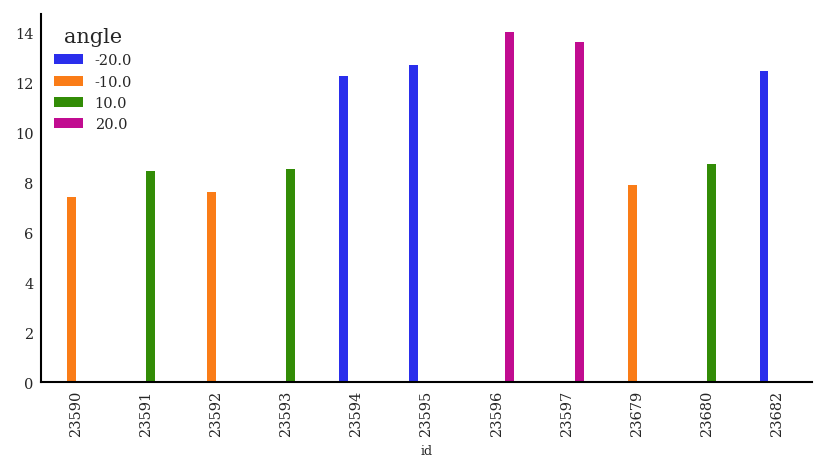

In [33]:
overshoot_results.pivot(index='angle', columns='id', values='overshoot_1').transpose().plot.bar()

<Axes: xlabel='angle'>

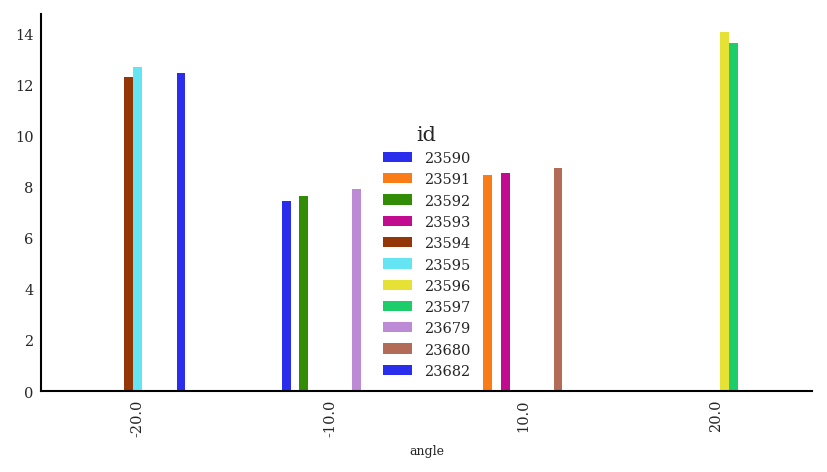

In [34]:
overshoot_results.pivot(index='angle', columns='id', values='overshoot_1').plot.bar()

In [35]:
overshoot_experiment_mean = overshoot_results.groupby(by='angle').mean()
overshoot_experiment_mean['model_name'] = 'Experiment'
overshoot_experiment_mean['angle'] = overshoot_experiment_mean.index

In [36]:
overshoot_results.groupby(by='angle').std()

,overshoot_1,t_1,overshoot_2,t_2,overshoot_3,t_3,id
angle,,,,,,,
-20.0,0.206580,0.113720,0.101601,0.334068,0.099988,0.269503,50.520623
-10.0,0.227591,0.398278,0.308653,0.707835,NaN,NaN,50.816664
10.0,0.134014,0.026458,0.162699,0.135281,NaN,NaN,50.816664
20.0,0.302530,0.070699,0.168781,0.127267,0.155845,0.028285,0.707107


In [37]:
_ = []
for id, model_simulations in simulations.items():

    meta_data = meta_datas_all.loc[id]
    
    for model_name, df_simulation in model_simulations.items():
        
        overshoots = IMO_evaluation.measure_overshoots(df_simulation, angle=meta_data['angle'])
        overshoot_result = pack_overshoots(overshoots)
        overshoot_result['id'] = id
        overshoot_result['model_name'] = model_name
        overshoot_result['angle'] = meta_data['angle']
        _.append(overshoot_result)
    
overshoot_simulation_results = pd.DataFrame(_)
overshoot_simulation_results = pd.concat((overshoot_simulation_results,overshoot_experiment_mean,))

In [38]:
overshoot_simulation_results['angle'] = overshoot_simulation_results['angle'].astype(int)

In [39]:
overshoot_simulation_results

,overshoot_1,t_1,overshoot_2,t_2,id,model_name,angle,overshoot_3,t_3
0.0,14.337090,15.320000,14.539567,40.400000,23596.000000,MMG_original,20,NaN,NaN
1.0,13.976212,15.330000,14.000518,40.180000,23596.000000,MMG_quadratic,20,NaN,NaN
2.0,12.609471,14.950000,16.792966,39.760000,23594.000000,MMG_original,-20,NaN,NaN
3.0,13.436154,15.150000,14.795143,40.190000,23594.000000,MMG_quadratic,-20,NaN,NaN
4.0,6.947730,14.680000,11.581471,40.560000,23591.000000,MMG_original,10,NaN,NaN
5.0,7.740813,15.130000,15.315860,42.790000,23591.000000,MMG_quadratic,10,NaN,NaN
6.0,6.232068,14.350000,13.262416,40.260000,23590.000000,MMG_original,-10,NaN,NaN
7.0,8.980508,16.050000,14.768570,43.580000,23590.000000,MMG_quadratic,-10,NaN,NaN
-20.0,12.471257,15.306665,13.951002,41.099999,23623.666667,Experiment,-20,10.912725,68.573334
-10.0,7.648029,16.986663,17.331543,48.246652,23620.333333,Experiment,-10,NaN,NaN


In [40]:
styles


{
    'VCT': {'style': 'k.', 'zorder': 100, 'lw': 0.7, 'label': 'VCT'},
    'Experiment': {'style': 'k-', 'zorder': 100, 'lw': 0.7, 'label': 'FRMT'},
    'polynomial rudder': {'style': '-', 'color': 'red', 'label': 'polynomial rudder'},
    'semiempirical rudder': {'style': '-', 'color': '#0000ff', 'label': 'semi-empirical rudder'},
    'measured rudder': {
        'style': '-',
        'color': '#00ff00',
        'zorder': -100,
        'alpha': 1,
        'label': 'measured rudder'
    },
    'MMG_rudder': {'style': 'm-', 'label': 'MMG rudder'},
    'MMG_original': {'style': 'c-', 'label': 'MMG original'},
    'MMG_quadratic': {'style': 'm-', 'label': 'MMG quadratic'}
}

In [41]:
def get_name(row):
    angle = row.name
    direction = "port" if angle > 0 else "stbd"
    name = f"{abs(angle):0.0f}/{abs(angle):0.0f} {direction}"
    return name

In [42]:
def get_colors(overshoot_simulation_results_pivot):
    colors = []
    for name in overshoot_simulation_results_pivot.columns:
        if name=='name':
            continue
    
        style= styles[name]
        color = style.get('color',style['style'][0])
        colors.append(color)
    return colors

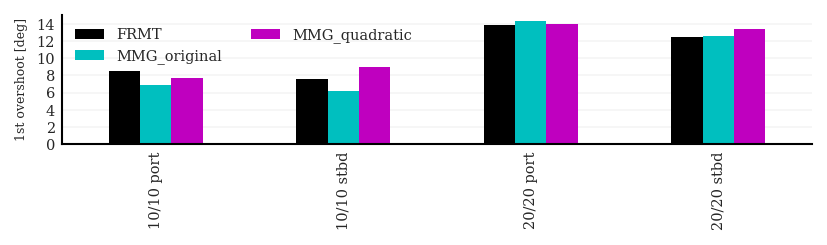

In [43]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_1')
colors = get_colors(overshoot_simulation_results_pivot)

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(get_name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.rename(columns={'Experiment':'FRMT'}, inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=colors, ax=ax)
ax.legend(ncols=2)
ax.set_xlabel('')
ax.set_ylabel('1st overshoot [deg]')

loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot1.svg")

In [44]:
df_overshoot_diff = overshoot_simulation_results_pivot.select_dtypes(exclude='object').sub(overshoot_simulation_results_pivot['FRMT'],axis=0)
df_overshoot_diff.abs().mean(numeric_only=True)


model_name
FRMT             0.000000
MMG_original     0.921657
MMG_quadratic    0.818968
dtype: float64

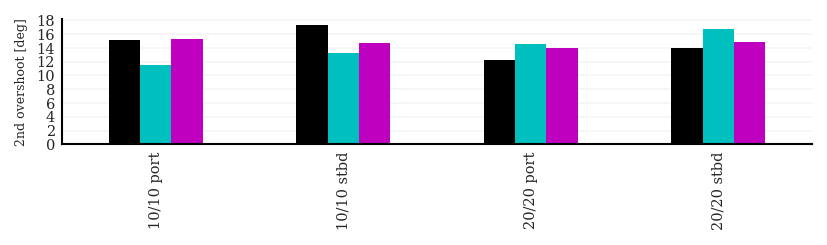

In [45]:
fig,ax=plt.subplots()
fig.set_size_inches((paper.figure_width,paper.figure_height/2))

overshoot_simulation_results_pivot = overshoot_simulation_results.pivot_table(index='angle', columns='model_name', values='overshoot_2')

overshoot_simulation_results_pivot['name'] = overshoot_simulation_results_pivot.apply(get_name, axis=1)
overshoot_simulation_results_pivot.sort_values(by='name', inplace=True)
overshoot_simulation_results_pivot.rename(columns={'Experiment':'FRMT'}, inplace=True)
overshoot_simulation_results_pivot.plot.bar(x='name', color=colors, ax=ax)

#ax.legend(ncols=3)
ax.get_legend().set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('2nd overshoot [deg]')

loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.grid(True, axis='y', which='major')

paper.save_fig(fig,"overshoot2.svg")

In [46]:
overshoot_simulation_results_pivot

model_name,FRMT,MMG_original,MMG_quadratic,name
angle,,,,
10,15.106862,11.581471,15.315860,10/10 port
-10,17.331543,13.262416,14.768570,10/10 stbd
20,12.294542,14.539567,14.000518,20/20 port
-20,13.951002,16.792966,14.795143,20/20 stbd


In [47]:
df_overshoot_diff

model_name,FRMT,MMG_original,MMG_quadratic
angle,,,
10,0.0,-1.627738,-0.834655
-10,0.0,-1.415961,1.332480
20,0.0,0.504717,0.143840
-20,0.0,0.138214,0.964896


In [48]:
df_overshoot_diff.abs().mean(axis=0)


model_name
FRMT             0.000000
MMG_original     0.921657
MMG_quadratic    0.818968
dtype: float64